<a href="https://colab.research.google.com/github/slvrsrfrrr/Machine-Learning/blob/main/imageGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## building a GAN model using tensorflow mnist dataset.

---



*   full model couldn't be trained due to computational limits




In [ ]:
#%pip install tensorflow-datasets ipywidgets

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
for gpu in gpus:
  print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [ ]:
ds = tfds.load('fashion_mnist', split='train')


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete03R0EN/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete03R0EN/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
import numpy as np


In [ ]:
dataiterator = ds.as_numpy_iterator()

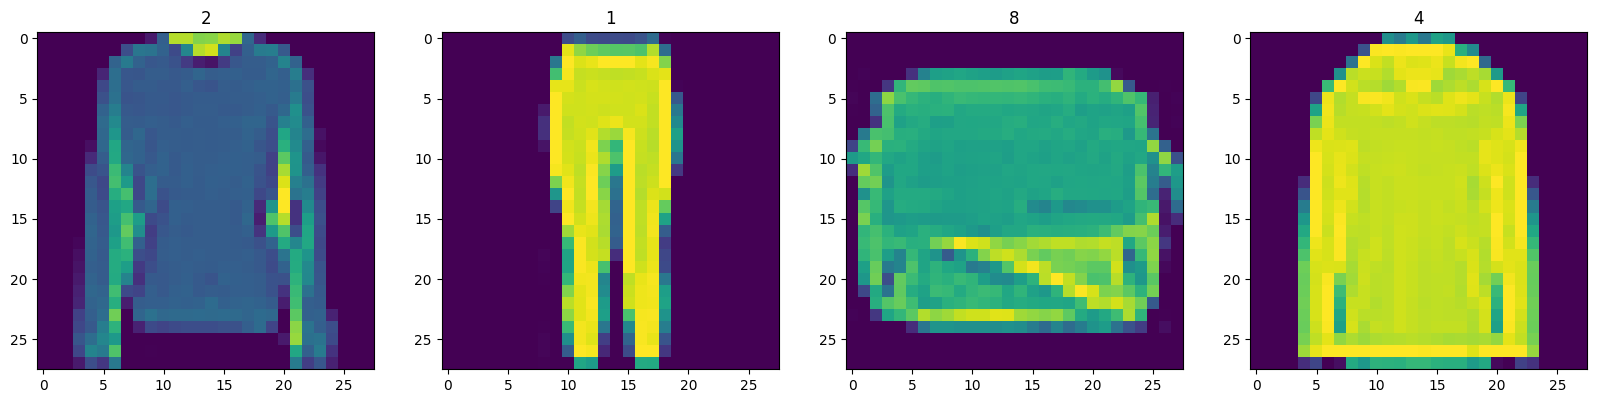

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  batch = dataiterator.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])

In [ ]:
def scale_images(data):
  image = data['image']
  return image /255



1.   map
2.   cache
3. shuffle
4. batch
5. prefetch



In [ ]:
ds = tfds.load('fashion_mnist', split='train')

ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [ ]:
from tensorflow import keras
from keras import models, layers


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D


In [ ]:
def build_generator():
  model = Sequential([

      Dense(7*7*128, input_dim=128),
      LeakyReLU(0.2),
      Reshape((7,7,128)),

      UpSampling2D(),
      Conv2D(128,5, padding='same'),
      LeakyReLU(0.2),

      UpSampling2D(),
      Conv2D(128,5, padding='same'),
      LeakyReLU(0.2),

      Conv2D(128,4, padding='same'),
      LeakyReLU(0.2),

      Conv2D(128,4, padding='same'),
      LeakyReLU(0.2),

      Conv2D(1,4, padding='same', activation='sigmoid')




  ])

  return model

In [ ]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [ ]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 2s 2s/step


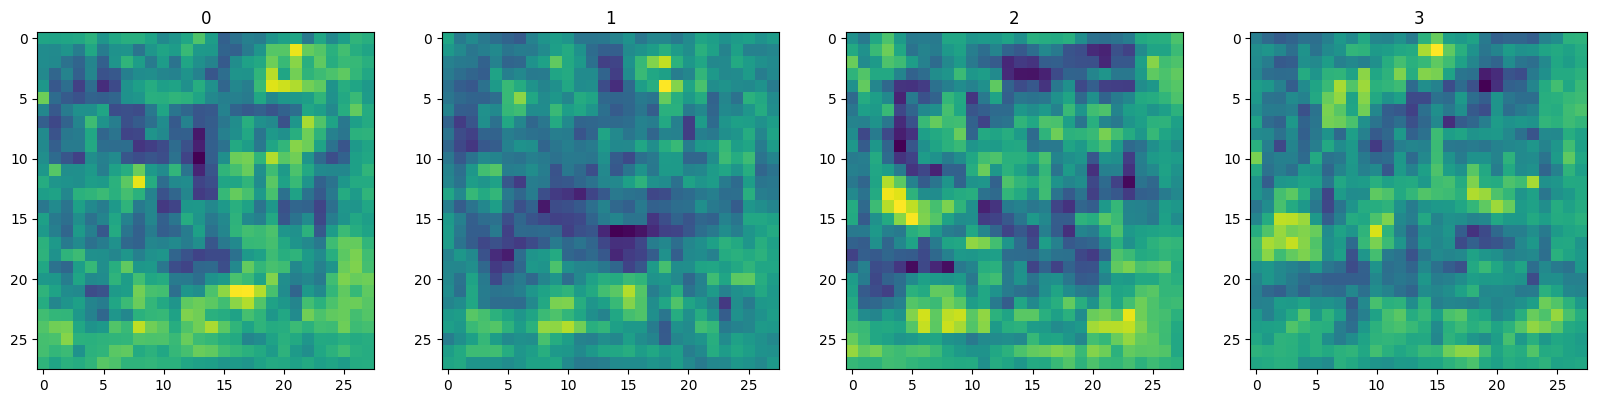

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

In [ ]:
def build_discriminator():
  model = Sequential([
      Conv2D(32,5, input_shape = (28,28,1)),
      LeakyReLU(0.2),
      Dropout(0.4),

      Conv2D(64,5),
      LeakyReLU(0.2),
      Dropout(0.4),

      Conv2D(128,5),
      LeakyReLU(0.2),
      Dropout(0.4),

      Conv2D(256,5),
      LeakyReLU(0.2),
      Dropout(0.4),

      Flatten(),
      Dropout(0.2),
      Dense(1, activation='sigmoid')




  ])
  return model

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
from keras.models import Model

In [ ]:
class FashionGAN(Model):

  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args,**kwargs)

    self.generator      = generator
    self.discriminator  = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args,**kwargs)

    self.g_opt    = g_opt
    self.d_opt    = d_opt
    self.g_loss   = g_loss
    self.d_loss   = d_loss

  def train_step(self, batch):

    real_images   = batch
    fake_images   = self.generator(tf.random.normal((128,128,1)), training=False)

    #TRAIN DISCRIMINATOR
    #=====================================
    with tf.GradientTape() as d_tape:

      yhat_real     = self.discriminator(real_images, training = True)
      yhat_fake     = self.discriminator(fake_images, training = True)
      yhat_realfake = tf.concat([yhat_real,yhat_fake], axis = 0)

      #create labels for real and fake images
      y_realfake    = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis = 0)

      #add some noise to the outputs
      noise_real    = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake    = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake    += tf.concat([noise_real, noise_fake], axis=0)

      #calculate loss
      total_d_loss  = self.d_loss(y_realfake, yhat_realfake)

      #apply backpropagation

    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    #TRAIN GENERATOR
    #=====================================
    with tf.GradientTape() as g_tape:

      #generate new images
      gen_images        = self.generator(tf.random.normal((128,128,1)), training = True)
      #create predicted labels
      predicted_labels  = self.discriminator(gen_images, training= False)
      #calculate loss
      total_g_loss      = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {'d_loss':total_d_loss, 'g_loss':total_g_loss}



In [ ]:
fashgan = FashionGAN(generator, discriminator)

In [ ]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
import os
from keras.preprocessing.image import array_to_img
from keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:  # Save every 100th epoch
            random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            for i in range(self.num_img):
                img = array_to_img(generated_images[i])
                img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [ ]:
hist = fashgan.fit(ds, epochs=500)

Epoch 1/500
469/469 [==============================] - 74s 158ms/step - d_loss: 0.2666 - g_loss: 2.6934
Epoch 2/500
469/469 [==============================] - 76s 161ms/step - d_loss: 0.2659 - g_loss: 2.6918
Epoch 3/500
469/469 [==============================] - 75s 161ms/step - d_loss: 0.2670 - g_loss: 2.6870
Epoch 4/500
469/469 [==============================] - 76s 161ms/step - d_loss: 0.2664 - g_loss: 2.6868
Epoch 5/500
469/469 [==============================] - 75s 161ms/step - d_loss: 0.2664 - g_loss: 2.6934
Epoch 6/500
469/469 [==============================] - 75s 161ms/step - d_loss: 0.2665 - g_loss: 2.6898
Epoch 7/500
469/469 [==============================] - 75s 161ms/step - d_loss: 0.2667 - g_loss: 2.6960
Epoch 8/500
469/469 [==============================] - 75s 161ms/step - d_loss: 0.2669 - g_loss: 2.6846
Epoch 9/500
469/469 [==============================] - 76s 161ms/step - d_loss: 0.2664 - g_loss: 2.6867
Epoch 10/500
469/469 [==============================] - 76s 161m

In [ ]:
imgs = generator.predict(tf.random.normal((16,128,1)))



1/1 [==============================] - 0s 32ms/step


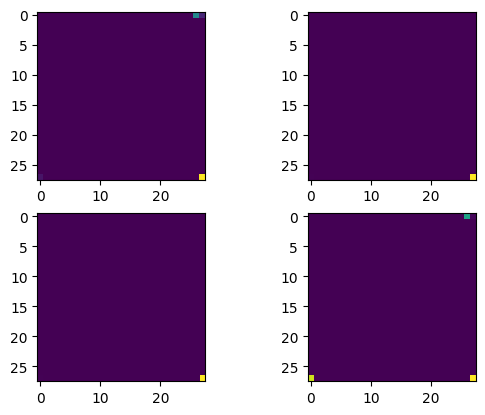

In [ ]:
fig, ax = plt.subplots(2, 2)

# Now, ax is a 2D array of Axes objects, and you can access them using indices
for r in range(2):
    for c in range(2):
        ax[r, c].imshow(imgs[(r + 1) * (c + 1) - 1])

plt.show()